In [43]:
#!pip install statsmodels
#!pip install openpyxl
#!pip show numpy
#!pip install seaborn
#!pip install networkx

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [51]:
# Standard library
import os
import sys
import time
import datetime
import itertools
import pickle
import warnings
import multiprocessing as mp

# Third-party libraries
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize, differential_evolution
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from numba import njit,jit
import matplotlib as mpl


from simulation_A import simulation as simulation_A
from simulation_B import simulation as simulation_B
from simulation_C import simulation as simulation_C
from simulation_D import simulation as simulation_D
from simulation_E import simulation as simulation_E
from simulation_F import simulation

warnings.filterwarnings("ignore", category=FutureWarning)
#from causallearn.graph.GraphUtils import GraphUtils
%matplotlib inline
os.environ["NUMEXPR_MAX_THREADS"] = "128"
print(scipy.__version__)

1.13.1


In [2]:
np.random.seed(42)
countries=['Israel', 'Mexico', 'Greece', 'Canada', 'Ukraine', 'Australia', 'Turkey', 'Bosnia and Herzegovina', 
                 'Portugal', 'Indonesia', 'Algeria', 'Poland', 'Ghana', 'Russia', 'Nigeria', 'Peru', 'India','Austria',
                'Thailand', 'Spain', 'Italy', 'Sweden', 'Ecuador', 'Colombia', 'Kenya',  'Kazakhstan', 'Mozambique',
                'Sri Lanka', 'Argentina', 'United Kingdom', 'Chile', 'Finland', 'United Arab Emirates', 'Malaysia', 'Germany', 
                'Vietnam', 'Ireland', 'Qatar', 'Japan', 'Brazil', 'Singapore', 'Slovakia', 'Saudi Arabia', 'South Korea','Czech Republic','Hungary','Netherlands']
n_countries = len(countries)  # Number of countries in the dataset
print(n_countries)

47


In [3]:
cal_date_range = pd.date_range(start='01/25/2020', end='01/25/2021', freq='D')
val_date_range = pd.date_range(start='01/26/2021', end='07/26/2021', freq='D')
date_range = pd.date_range(start='01/25/2020', end='07/26/2021', freq='D')

In [4]:
#input signals
file_name='Data/new_deaths_mil.pickle'
new_death_df =pd.read_pickle(file_name)

file_name='Data/new_cases_mil.pickle'
new_case_df =pd.read_pickle(file_name)

file_name='Data/policy.pickle'
policy_df=pd.read_pickle(file_name)

#For calibration over entire time period
file_name='Data/mask_complete.pickle'
mask_df=pd.read_pickle(file_name)


# Split into calibration and validation periods for temporal validation
file_name='Data/mask_validation.pickle'
mask_df_val=pd.read_pickle(file_name)


file_name='Data/mask_calibration.pickle'
mask_df_cal=pd.read_pickle(file_name)
    


In [5]:
# Build a lightweight data cache keyed by country_id
country_data = []
for i, country in enumerate(countries):
    di = new_death_df.loc[new_death_df['country'] == country, 'Deaths per mil'].to_numpy()
    pm = policy_df.loc[policy_df['Country'] == country, 'H6M_Facial Coverings'].to_numpy()

    idx_all = mask_df.loc[mask_df['country'] == country, 'days_from_reference'].to_numpy(dtype=int)
    idx_cal = mask_df_cal.loc[mask_df_cal['country'] == country, 'days_from_reference'].to_numpy(dtype=int)
    idx_val = mask_df_val.loc[mask_df_val['country'] == country, 'days_from_reference'].to_numpy(dtype=int)
    mask_obs_cal=  mask_df_cal[mask_df_cal['country'] == country]['pct']
    mask_obs_val=  mask_df_val[mask_df_val['country'] == country]['pct']
    mask_obs=  mask_df[mask_df['country'] == country]['pct']

    country_data.append({
        'country': country,
        'disease_incidence': di,
        'policy_mandates': pm,
        'idx_all': idx_all,
        'idx_cal': idx_cal,
        'idx_val': idx_val,
        'mask_obs': mask_obs,
        'mask_obs_cal': mask_obs_cal,
        'mask_obs_val': mask_obs_val
        
    })




In [63]:
# Predict mask-wearing behavior with current parameters

def country_predicted(di, pm, params, mu, beta, model):
    if model == 'A':
        return simulation_A(di, pm, params, mu, beta)
    elif model == 'B':
        return simulation_B(di, pm, params, mu, beta)
    elif model == 'C':
        return simulation_C(di, pm, params, mu, beta)
    elif model == 'D':
        return simulation_D(di, pm, params, mu, beta)
    elif model == 'E':
        return simulation_E(di, pm, params, mu, beta)
    else:
        return simulation(di, pm, params, mu, beta)

# Function to calculate error for one country
  


def country_error(params, di, pm, idx, y_obs, mu, beta, model):
    # RMSE 
    pred = country_predicted(di, pm, params, mu, beta, model)
    resid = y_obs - pred[idx]
    return (resid @ resid) ** 0.5 / resid.size**0.5

# ---- multiprocessing worker globals ----
_GLOBAL = {}
#_GLOBAL['country_data'] = country_data
def _init_worker_boot(country_data_, y_obs_boot_list_):
    # store references (no copies) in worker memory
    _GLOBAL['country_data'] = country_data_
    _GLOBAL['yobs'] = y_obs_boot_list_


    
def optimized_boot(mu, beta, country_id, boot_idx, period, param_bounds,model):
    cd = _GLOBAL['country_data'][country_id]
    di, pm = np.array(cd['disease_incidence']), np.array(cd['policy_mandates'])
    idx = cd['idx_cal'] if period == 'cal' else (cd['idx_val'] if period == 'val' else cd['idx_all'])
    y_obs = _GLOBAL['yobs'][country_id, boot_idx]
      
   
    def obj(p):
        return country_error(p, di, pm, idx, y_obs, mu, beta, model)

    res = differential_evolution(obj, bounds=param_bounds,popsize=15,strategy='best1bin',seed=42,tol=1e-3)
    return res.x, res.fun
    
def _init_worker(country_data_):
    # store references (no copies) in worker memory
    _GLOBAL['country_data'] = country_data_
        
def optimized_grid(mu, beta, country_id, period, param_bounds,model):
    cd = _GLOBAL['country_data'][country_id]
    di, pm = np.array(cd['disease_incidence']), np.array(cd['policy_mandates'])
    idx = cd['idx_cal'] if period == 'cal' else (cd['idx_val'] if period == 'val' else cd['idx_all'])
    y_obs = cd['mask_obs_cal'] if period == 'cal' else (cd['mask_obs_val'] if period == 'val' else cd['mask_obs'])
    
    def obj(p):
        return country_error(p, di, pm, idx, y_obs, mu, beta, model)

    res = differential_evolution(obj, bounds=param_bounds,popsize=24,strategy='best1bin',seed=42,tol=1e-3)
    return res.x, res.fun


In [7]:
def combine_country_dataframes(dataframes, country_column="Country"):
    """
    Combines a list of dataframes with country-level data, ensuring that missing variables for some countries
    are represented as NaN.

    Parameters:
    - dataframes (list of pd.DataFrame): List of dataframes to combine.
    - country_column (str): The name of the column that identifies countries. Defaults to "country".

    Returns:
    - pd.DataFrame: Combined dataframe with all variables and countries.
    """
    # Start with an empty dataframe with the country column as a base
    combined_df = pd.DataFrame()
    
    for df in dataframes:
        # Ensure the country column exists
        if country_column not in df.columns:
            raise ValueError(f"Each dataframe must contain a '{country_column}' column.")
        
        # Merge the current dataframe with the combined one on the country column
        if combined_df.empty:
            combined_df = df.copy()
        else:
            combined_df = pd.merge(combined_df, df, on=country_column, how="outer")
    
    return combined_df

# Tuning the rate of decision review (mu) and the rationality of decision-making (beta)

In [8]:
n_countries = len(countries)  # Number of countries in the dataset
period='complete'
models=['A','B','C','D','E','F']
num_of_parmeters_list=[1,1,2,2,2,3] # Number of parameters to optimize for each country

model='F'  # Choose the model to use for simulation

if model in ['A','B']:
    param_bounds=[(1e-5,20)] 
elif model in ['C','D','E']:
    param_bounds=[(1e-5,20),(1e-5, 20)]   
else:
    param_bounds=[(1e-5,20),(1e-5, 20),(1e-5,20)]     
    
start_time = datetime.datetime.now()



num_of_parameters=len(param_bounds)  # Number of parameters to optimize for each country

mu_list=np.linspace(0.4,1.0,20)
beta_list=np.linspace(0.2,0.5,20)

n_countries = len(countries)  # Number of countries in the dataset



print("Simulation started at:", start_time.strftime("%H:%M"))
st = time.time()

tasks=[]
for mu, beta, i in itertools.product(mu_list,beta_list,range(n_countries)):
     
    tasks.append((mu, beta, i, period, param_bounds,model))
    

with mp.Pool(processes=144, initializer=_init_worker,
          initargs=(country_data,)) as p:
    chunksize = max(1, len(tasks) // (144 * 8))
    # tasks is a list of tuples matching optimize_one's signature
    results = p.starmap(optimized_grid, tasks, chunksize=chunksize)

country_params_list, error_list = zip(*results)

et = time.time()
elapsed_time = et - st
print('Calibration time:', elapsed_time, 'seconds')


Simulation started at: 15:03
Calibration time: 110.93662571907043 seconds


In [9]:
country_params_list=np.array(country_params_list)
country_params_list.shape=(len(mu_list),len(beta_list),n_countries,num_of_parameters)

error_list=np.array(error_list)
error_list.shape=(len(mu_list),len(beta_list),n_countries)


In [10]:
error_list1=np.zeros((len(mu_list),len(beta_list)))

for i in range(len(mu_list)):
    for ii in range(len(beta_list)):
        for iii in range(n_countries):
            error_list1[i,ii]+=error_list[i,ii,iii]**2

error_list1=np.sqrt(error_list1/n_countries)

min_idx = np.unravel_index(np.argmin(error_list1), error_list1.shape)

Minimum error: 0.0638
mu: 1.0
beta: 0.2947368421052632


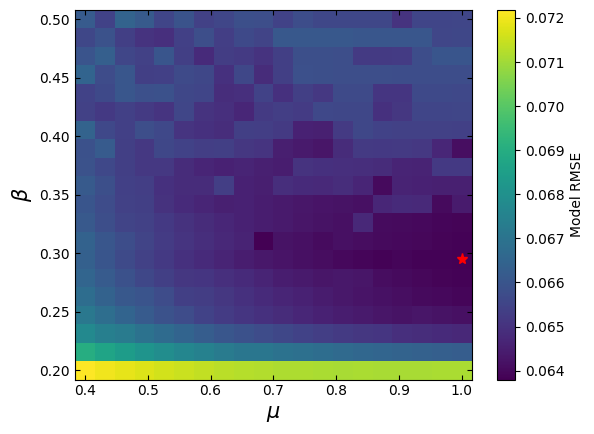

In [11]:
# Get corresponding values
mu_val = mu_list[ min_idx[0]]   
beta_val = beta_list[min_idx[1]]
min_error = error_list1[ min_idx[0], min_idx[1]]


print(f"Minimum error: {min_error:.4f}")
print(f"mu: {mu_val}")
print(f"beta: {beta_val}")  

fig, ax = plt.subplots()
cmap = plt.cm.viridis

X, Y = np.meshgrid(mu_list[:], beta_list[:])

c=ax.pcolormesh(X, Y, error_list1[:,:].T, cmap=cmap,shading='auto')



ax.plot(mu_val, beta_val, marker='*', color='red', markersize=8, label='Min Error')


ax.set_ylabel(r'$\beta$',fontsize=15)
ax.set_xlabel(r'$\mu$ ',fontsize=15)

plt.colorbar(c,ax=ax,label='Model RMSE' )

ax.tick_params(bottom=True, top=True, left=True, right=True,direction="in")
plt.show()
#fig.savefig("beta_mu_heatmap.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)

In [12]:
er_list_1= error_list[min_idx]
#print(er_list)
t=np.sum([x**2 for x in er_list_1])
t=t/47
t=np.sqrt(t)
print(t)
print(np.median(er_list_1))
print(np.mean(er_list_1))
mu = mu_list[ min_idx[0]]   
beta = beta_list[min_idx[1]]

cal_error=error_list[min_idx]
country_params=country_params_list[min_idx]

0.06379801305814786
0.04962140813084096
0.0564935812817186


## Bootstrapping using residuals

In [21]:
B = 100  # number of bootstraps

# Print the start time
st = time.time()
rng = np.random.default_rng(42)
y_obs_boot_list=np.zeros((n_countries,B,458))

for i in range(n_countries):

    cd = country_data[i]
    di, pm = np.array(cd['disease_incidence']), np.array(cd['policy_mandates'])

    idx = cd['idx_all'] 
    y_obs = cd['mask_obs'] 
    
    y_pred = country_predicted(di, pm, country_params[i], mu, beta, model)
    y_pred_obs  = y_pred[idx]
    residuals = y_obs - y_pred_obs
    T_obs     = residuals.size

    # draw B bootstrap residual rows at once (block_len=1 -> i.i.d. resampling)
    boot_residuals = rng.choice(residuals, size=(B, T_obs), replace=True)

    # construct bootstrap pseudo-observations
    y_obs_boot_list[i, :B, :T_obs] = y_pred_obs + boot_residuals
    

et = time.time()
elapsed_time = et - st
print('Time taken:', elapsed_time, 'seconds')



Time taken: 0.027925968170166016 seconds


## Calibrating for bootstraps

In [23]:
start_time = datetime.datetime.now()
print("Simulation started at:", start_time.strftime("%H:%M"))
st = time.time()

# Build a *small* iterable of args (ints + small arrays)
tasks = []

# mu_list_boot=mu_list
# beta_list_boot=beta_list
mu_list_boot=np.linspace(0.7,1.0,20)
beta_list_boot=np.linspace(0.25,0.4,20)

for mu1, beta1, i, b in itertools.product(mu_list_boot,beta_list_boot,
                                                range(n_countries),
                                                range(B)):
    
    tasks.append((mu1, beta1, i, b, period, param_bounds,model))

with mp.Pool(processes=144, initializer=_init_worker_boot,
          initargs=(country_data, y_obs_boot_list)) as p:
    chunksize = max(1, len(tasks) // (144 * 8))
    # tasks is a list of tuples matching optimize_one's signature
    results = p.starmap(optimized_boot, tasks, chunksize=chunksize)

theta_boots_list, boot_error_list = zip(*results)
theta_boots_list=np.array(theta_boots_list)
theta_boots_list.shape=(len(mu_list_boot),len(beta_list_boot),n_countries,B,num_of_parameters)
boot_error_list=np.array(boot_error_list)
boot_error_list.shape=(len(mu_list_boot),len(beta_list_boot),n_countries,B)

et = time.time()
elapsed_time = et - st
print('Calibration time:', elapsed_time, 'seconds')

Simulation started at: 15:16
Calibration time: 2178.102524995804 seconds


In [25]:
B=100
# with open('bootstrap_data_F.pickle', 'rb') as f:
#     theta_boots_list,boot_error_list,mu_list_boot,beta_list_boot= pickle.load(f)

mu_boot=np.zeros(B)
mu_boot_idx=np.zeros(B,dtype=np.intp)
beta_boot=np.zeros(B)
beta_boot_idx=np.zeros(B,dtype=np.intp)

for b_idx in range(B):
    error_list3=np.zeros((len(mu_list_boot),len(beta_list_boot)))
    for i in range(len(mu_list_boot)):
        for ii in range(len(beta_list_boot)):
            for iii in range(n_countries):
                error_list3[i,ii]+=boot_error_list[i,ii,iii,b_idx]**2
    error_list3=np.sqrt(error_list3/n_countries)            
    min_idx = np.unravel_index(np.argmin(error_list3), error_list3.shape)
    mu_boot[b_idx] = mu_list_boot[ min_idx[0]]   
    beta_boot[b_idx] = beta_list_boot[min_idx[1]]
    mu_boot_idx[b_idx] = int(min_idx[0])
    beta_boot_idx[b_idx]= int(min_idx[1])



#print(mu_boot_idx)

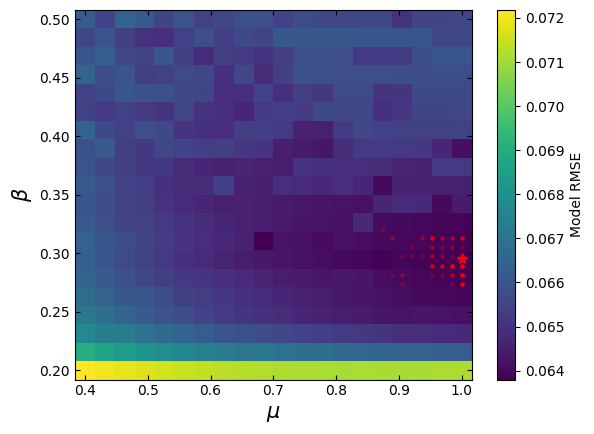

In [26]:
fig, ax = plt.subplots()
cmap = plt.cm.viridis

X, Y = np.meshgrid(mu_list[:], beta_list[:])

c=ax.pcolormesh(X, Y, error_list1[:,:].T, cmap=cmap,shading='auto')
ax.scatter(mu_boot,beta_boot,alpha=0.2,c='r', s=5)
ax.plot(mu_val, beta_val, marker='*', color='red', markersize=8, label='Min Error')
ax.set_ylabel(r'$\beta$',fontsize=15)
ax.set_xlabel(r'$\mu$ ',fontsize=15)
#ax.set_xlim(min(mu_list),max(mu_list))
#ax.set_ylim(min(beta_list),max(beta_list))
plt.colorbar(c,ax=ax,label='Model RMSE' )

ax.tick_params(bottom=True, top=True, left=True, right=True,direction="in")
#fig.savefig("beta_mu_heatmap_boots.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)
plt.show()

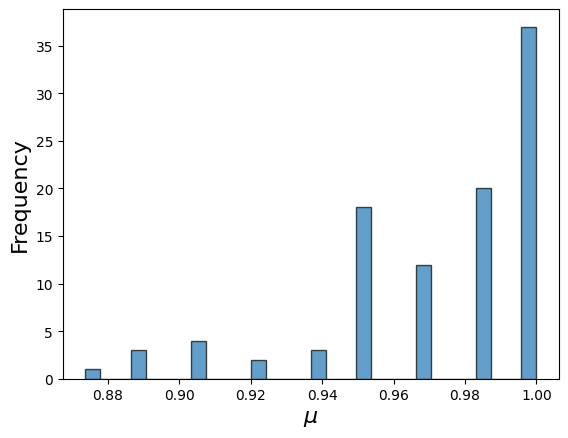

In [27]:
plt.hist(mu_boot, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel(r"$\mu$",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
#plt.title("mu distribution")
plt.savefig("mu_distribution.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)
plt.show()

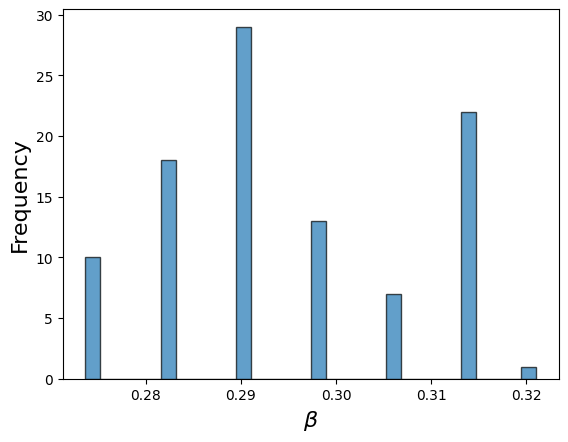

In [28]:
plt.hist(beta_boot, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel(r"$\beta$",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
#plt.title("beta distribution")
#plt.savefig("beta_distribution.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)
plt.show()
#print(beta_boot)

In [ ]:
# with open('bootstrap_data_F.pickle','wb') as f:
#     pickle.dump((theta_boots_list, boot_error_list,mu_list_boot,beta_list_boot),f)

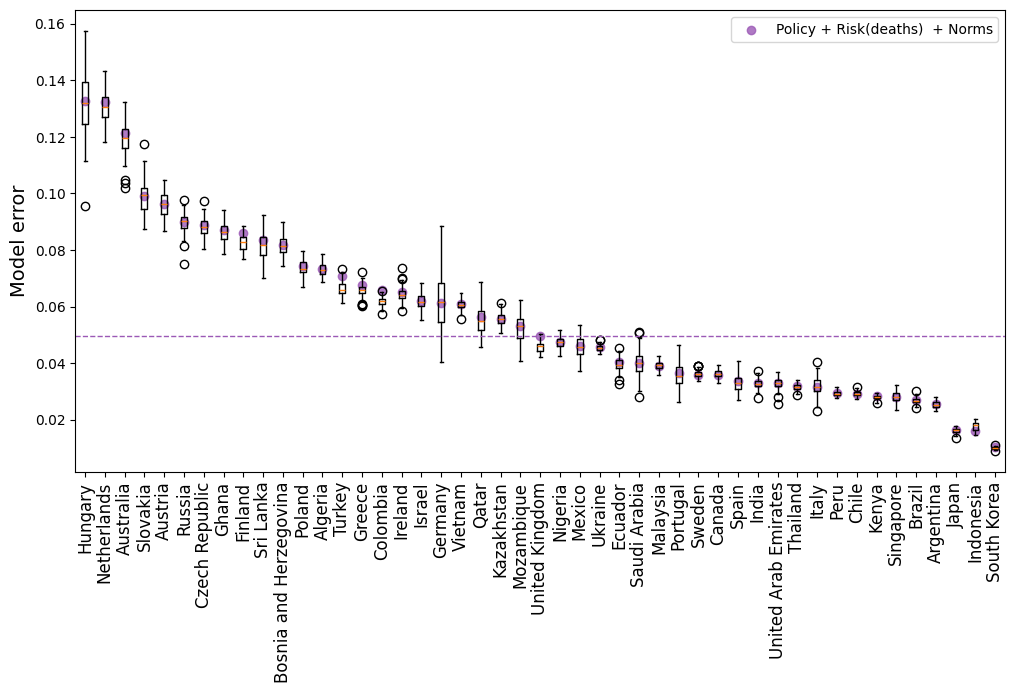

In [29]:
colors=['#1abc9c','#e67e22','#3498db','#9b59b6']
#boot_error_list.shape=(len(mu_list),len(beta_list),n_countries,B)

sorted_indices = np.argsort(cal_error)[::-1]

# Sorting countries and errors accordingly
sorted_countries = np.array(countries)[sorted_indices]
sorted_errors = np.array(cal_error)[sorted_indices]
boot_error=np.zeros((47,B))
for i in range(B):
    boot_error[:,i]=boot_error_list[mu_boot_idx[i],beta_boot_idx[i],:,i]

sorted_boot_error=boot_error[sorted_indices]

sorted_countries_model=sorted_countries
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(list(sorted_boot_error), positions=range(len(countries)), widths=0.3)
ax.scatter(sorted_countries, sorted_errors,label="Policy + Risk(deaths)  + Norms",c=colors[3],alpha=0.8)


ax.axhline(y=np.median(cal_error),linestyle='--',linewidth=1,c=colors[3])

plt.xticks(range(len(countries)), labels=sorted_countries, rotation=90, fontsize=12)
plt.xticks(rotation=90)
#plt.title("Error in predicted mask usage in calibration")
#plt.xlabel("Country",fontsize='14')
plt.ylabel("Model error",fontsize='14')
plt.legend()
plt.show()
#fig.savefig("Cal_error_cases.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)

In [30]:
#variation in mask usage over time

data_var=[]

for i in range(n_countries):
    cd = country_data[i]
    
    y_obs = cd['mask_obs'] 
    data_var.append(np.std(y_obs))
 

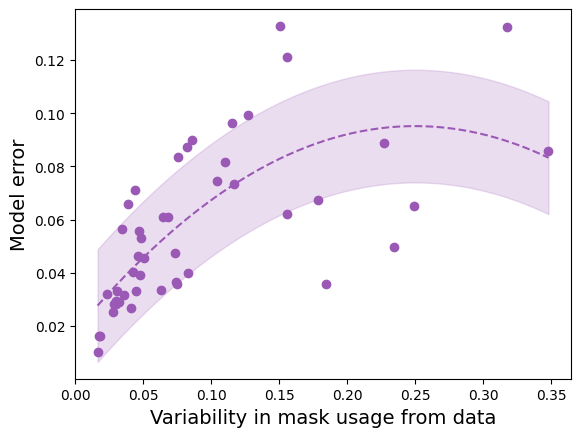

In [31]:
fig, ax = plt.subplots()

# Scatter plots
#ax.scatter(data_var_A, cal_error_A, label="Policy", c=colors[0])
#ax.scatter(data_var_C, cal_error_C, label="Policy and Risk perception", c=colors[1])
#ax.scatter(data_var_E, cal_error_E, label="Policy and Conformity", c=colors[2])
ax.scatter(data_var, cal_error, label="Policy, Risk  and Norm", c=colors[3])
x=data_var
y=cal_error
color=colors[3]
#label= 
# Quadratic fits with confidence bands
# for x, y, color, label in zip(
#     [data_var_A, data_var_C, data_var_E, data_var],
#     [cal_error_A, cal_error_C, cal_error_E, cal_error],
#     colors,
#     ['A', 'C', 'E', 'G']
# ):
coeffs = np.polyfit(x, y, 2)
x_fit = np.linspace(min(x), max(x), 200)
y_fit = np.polyval(coeffs, x_fit)

# Estimate spread as std of residuals
y_pred = np.polyval(coeffs, x)
residuals = y - y_pred
spread = np.std(residuals)

# Plot fit and spread
ax.plot(x_fit, y_fit, linestyle='--', color=color)
ax.fill_between(x_fit, y_fit - spread, y_fit + spread, color=color, alpha=0.2)

# Labels and legend
ax.set_xlabel("Variability in mask usage from data",fontsize='14')
ax.set_ylabel("Model error",fontsize='14')
plt.show()
#ax.legend()
#fig.savefig("Cal_error_vs_data_var.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)

In [32]:


df = pd.DataFrame(country_params, columns=['Risk weight','Norm weight', 'Policy weight'])


# Add a column for countries (optional)
df['Country'] = [country for country in countries]
df['Error'] =cal_error 



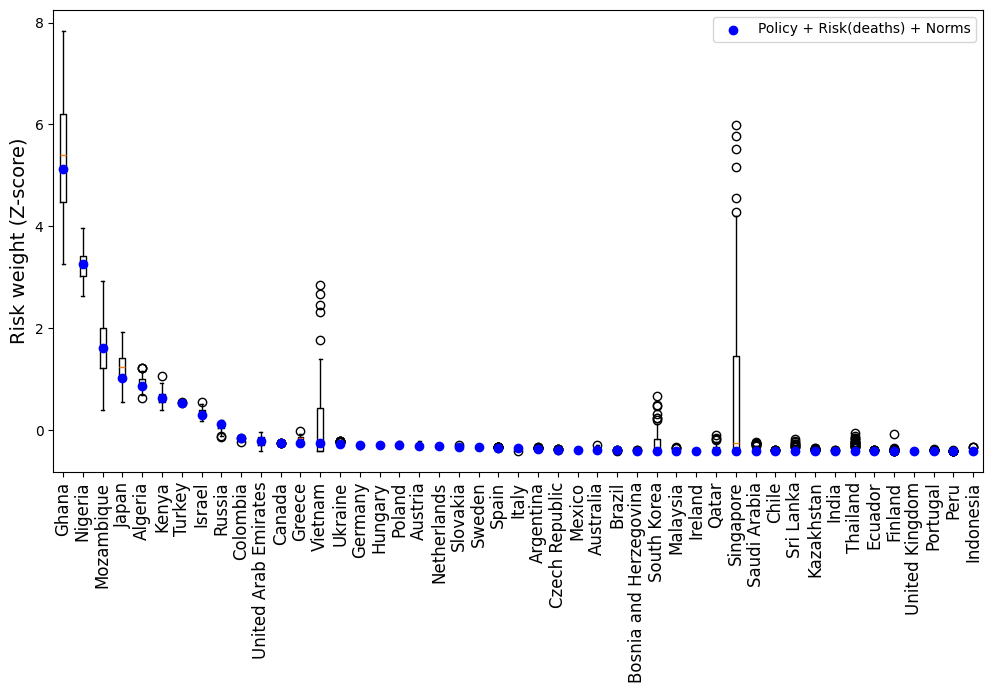

In [33]:
# 1. Get param_list and compute mean and std
#colors=['#3498db','#9b59b6']
param_list = country_params[:, 0]
mean_val = param_list.mean()
std_val = param_list.std()


# 2. Standardize param_list
param_list_std = (param_list - mean_val) / std_val


# 3. Sort
sorted_indices = np.argsort(param_list_std)[::-1]
sorted_countries = np.array(countries)[sorted_indices]
sorted_param = param_list_std[sorted_indices]

theta_boots=np.zeros((47,B,3))
for i in range(B):
    theta_boots[:,i,0]=theta_boots_list[mu_boot_idx[i],beta_boot_idx[i],:,i,0]

# 4. Standardize theta_boots using the same mean and std
theta_boots_std = (theta_boots[:,:,0] - mean_val) / std_val
sorted_boots = theta_boots_std[sorted_indices]

# 5. Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(list(sorted_boots), positions=range(len(countries)), widths=0.3)
ax.scatter(range(len(countries)), sorted_param, zorder=3,color='b',label='Policy + Risk(deaths) + Norms')
ax.legend()
plt.xticks(range(len(countries)), labels=sorted_countries, rotation=90, fontsize=12)
plt.ylabel("Risk weight (Z-score)", fontsize=14)
plt.show()
#fig.tight_layout()
#fig.savefig("Risk_standardized.jpeg", dpi=400, bbox_inches='tight', pad_inches=0.1)

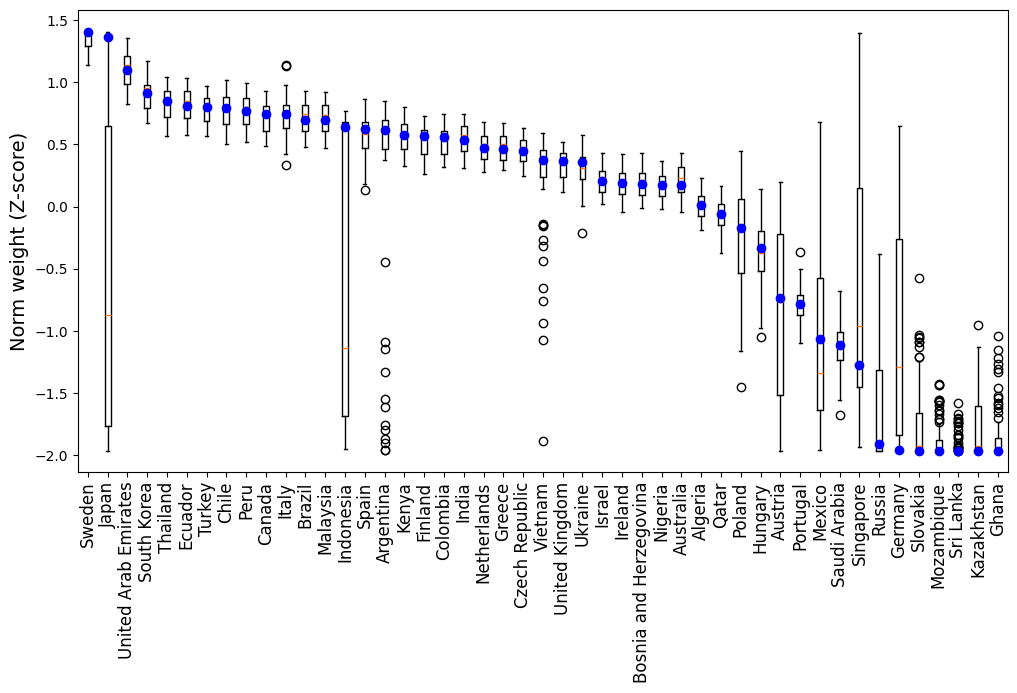

In [34]:
# 1. Get param_list and compute mean and std
param_list = country_params[:, 1]
mean_val = param_list.mean()
std_val = param_list.std()

# 2. Standardize param_list
param_list_std = (param_list - mean_val) / std_val


# 3. Sort
sorted_indices = np.argsort(param_list_std)[::-1]
sorted_countries = np.array(countries)[sorted_indices]
sorted_param = param_list_std[sorted_indices]


for i in range(B):
    theta_boots[:,i,1]=theta_boots_list[mu_boot_idx[i],beta_boot_idx[i],:,i,1]
    
# 4. Standardize theta_boots using the same mean and std
theta_boots_std = (theta_boots[:,:,1] - mean_val) / std_val
sorted_boots = theta_boots_std[sorted_indices]

# 5. Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(list(sorted_boots), positions=range(len(countries)), widths=0.3)
ax.scatter(range(len(countries)), sorted_param, color='b', zorder=3)

plt.xticks(range(len(countries)), labels=sorted_countries, rotation=90, fontsize=12)
plt.ylabel("Norm weight (Z-score)", fontsize=14)
plt.show()
#fig.tight_layout()
#fig.savefig("conformity_standardized.jpeg", dpi=400, bbox_inches='tight', pad_inches=0.1)

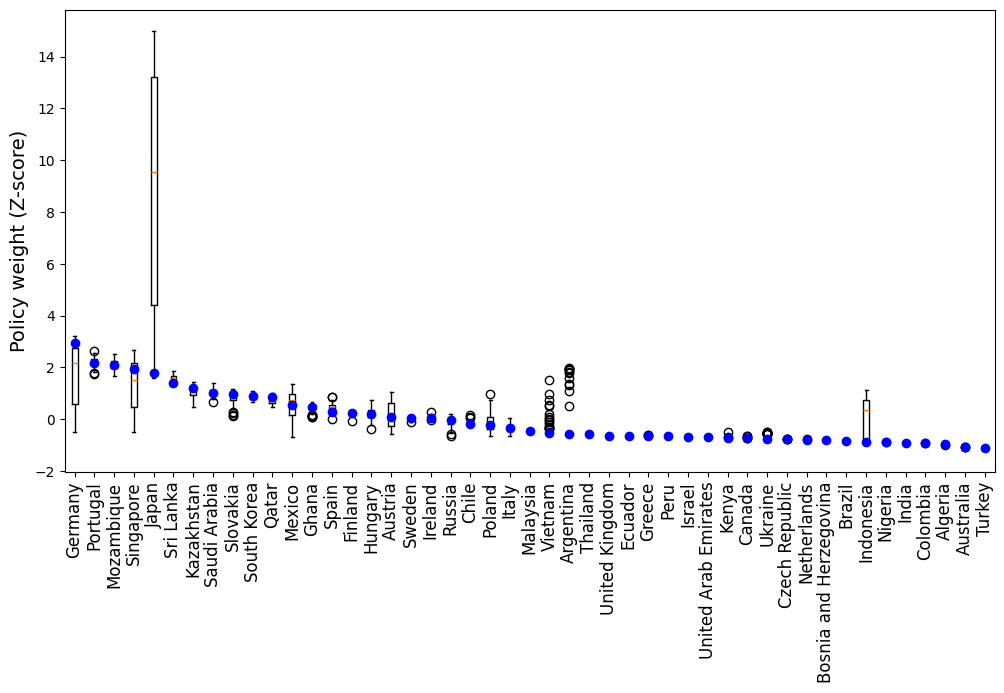

In [35]:
# 1. Get param_list and compute mean and std
param_list = country_params[:, 2]
mean_val = param_list.mean()
std_val = param_list.std()

# 2. Standardize param_list
param_list_std = (param_list - mean_val) / std_val


# 3. Sort
sorted_indices = np.argsort(param_list_std)[::-1]
sorted_countries = np.array(countries)[sorted_indices]
sorted_param = param_list_std[sorted_indices]


for i in range(B):
    theta_boots[:,i,2]=theta_boots_list[mu_boot_idx[i],beta_boot_idx[i],:,i,2]


# 4. Standardize theta_boots using the same mean and std
theta_boots_std = (theta_boots[:,:,2] - mean_val) / std_val
sorted_boots = theta_boots_std[sorted_indices]
sorted_boots = theta_boots_std[sorted_indices]

# 5. Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(list(sorted_boots), positions=range(len(countries)), widths=0.3)
ax.scatter(range(len(countries)), sorted_param, color='b', zorder=3)

plt.xticks(range(len(countries)), labels=sorted_countries, rotation=90, fontsize=12)
plt.ylabel("Policy weight (Z-score)", fontsize=14)
plt.show()
#fig.tight_layout()
#fig.savefig("policy_standardized.jpeg", dpi=400, bbox_inches='tight', pad_inches=0.1)

In [36]:
theta_sd=np.std(theta_boots,axis=1)
boot_mean=np.mean(theta_boots,axis=1)
df['Risk_weight_sd']=theta_sd[:,0]
df['Norm_weight_sd']=theta_sd[:,1]
df['Policy_weight_sd']=theta_sd[:,2]
    

# Reorder columns to put 'Country' first (optional)
CP_df = df[['Country', 'Risk weight', 'Norm weight', 'Policy weight','Risk_weight_sd','Norm_weight_sd','Policy_weight_sd']]
CP_df['Risk weight(log)']=np.log(CP_df['Risk weight'])

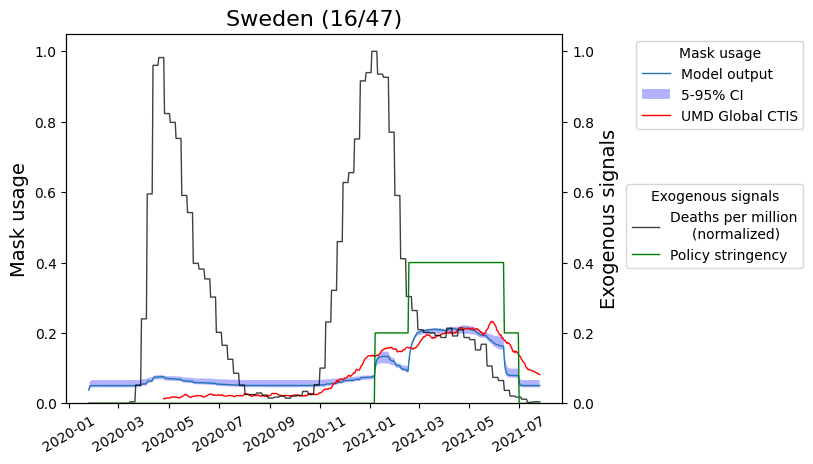

In [72]:
country='Sweden'
country_id=countries.index(country)
disease_incidence = np.array(new_death_df[new_death_df['country'] == country]['Deaths per mil'])
policy_mandates = np.array(policy_df[policy_df['Country'] == country]['H6M_Facial Coverings'])
mask_predicted=country_predicted(disease_incidence, policy_mandates, country_params[country_id], mu, beta, model)


mask_umd_val = mask_df_val[mask_df_val['country'] == country]['pct']
mask_umd_cal = mask_df_cal[mask_df_cal['country'] == country]['pct']
mask_umd=mask_df[mask_df['country'] == country]['pct']
date_umd=mask_df[mask_df['country'] == country]['days_from_reference']


fig,ax= plt.subplots()
ax.set_ylim(0,1.05)
ax.plot(date_range,mask_predicted,label='Model output', linewidth=1)

mask_predictions = np.zeros((B, len(mask_predicted)))

# Generate predictions for each bootstrap run
for i in range(B):
    params=theta_boots_list[mu_boot_idx[i],beta_boot_idx[i],country_id, i]
    
    mask_predictions[i, :] = country_predicted(disease_incidence, policy_mandates,params, mu_boot[i],beta_boot[i],model)

lower_bound = np.percentile(mask_predictions, 2.5, axis=0)
upper_bound = np.percentile(mask_predictions, 97.5, axis=0)
ax.fill_between(date_range, lower_bound, upper_bound, color='b',edgecolor=None, alpha=0.3, label="5-95% CI")
    
plt.xticks(rotation=30)
ax2=ax.twinx()
disease_incidence=(disease_incidence-min(disease_incidence))/(max(disease_incidence)-min(disease_incidence))
policy_mandates=(policy_mandates-min(policy_mandates))/5
ax2.plot(date_range,disease_incidence,label='Deaths per million\n     (normalized) ',c='k',alpha=0.75, linewidth=1)
ax2.plot(date_range,policy_mandates,label='Policy stringency',c='green',alpha=1, linewidth=1)
ax.plot(date_range[date_umd],mask_umd,label='UMD Global CTIS',c='r', linewidth=1)

ax2.set_ylim(0,)
title=country+' ('+ str(47-list(sorted_countries_model).index(country))+'/47)'
ax.set_ylabel('Mask usage',fontsize=14)
ax2.set_ylabel('Exogenous signals',fontsize=14)
ax.set_title(title,fontsize=16)



ax.legend(loc='upper right',fontsize="10", bbox_to_anchor=(1.5, 1),title='Mask usage',ncol=1)
ax2.legend(loc='center right',fontsize="10", bbox_to_anchor=(1.5, 0.48),title='Exogenous signals',ncol=1)
plt.show()
#fig.savefig(country+'.jpeg',dpi=400,bbox_inches='tight', pad_inches=0.1)

# Checking association of decision weights with known Social, economic and cultural indicators

In [40]:
file_name='Data/control_variables.pickle'
CV_df=pd.read_pickle(file_name)


file_name = 'Data/collectivism.pickle'
coll_df=pd.read_pickle(file_name)


# file_name='Data/trust.pickle'
# trust_df=pd.read_pickle(file_name)

    
file_path = 'Data/Tightness_Scores.xlsx'
conformity_df = pd.read_excel(file_path)


dataframes = [CP_df, conformity_df,coll_df, CV_df]
df = combine_country_dataframes(dataframes)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#df = df.rename(columns={'Score': 'Trust'})

df = df[df['Country'].isin(countries)]
df["Population density(log)"] =   np.log(df['Population_density'])
df["GDP per capita(log)"] =   np.log(df["GDP"])
#df["conf_pop"]=df["Norm_weight"]/df["Population_density"]

print(df)   


                    Country  Risk weight  Norm weight  Policy weight  \
2                   Algeria     1.929514    11.684713       0.299387   
6                 Argentina     0.045310    15.296415       0.585377   
9                 Australia     0.019391    12.641680       0.228663   
10                  Austria     0.144193     7.286664       1.053915   
22   Bosnia and Herzegovina     0.004670    12.710567       0.406224   
24                   Brazil     0.016461    15.771586       0.377347   
32                   Canada     0.241713    16.044399       0.469422   
36                    Chile     0.000010    16.336933       0.877812   
38                 Colombia     0.374429    14.929785       0.330355   
47           Czech Republic     0.033238    14.283284       0.442436   
55                  Ecuador     0.000010    16.437960       0.540151   
65                  Finland     0.000010    14.982201       1.170392   
71                  Germany     0.185832     0.051464       3.13

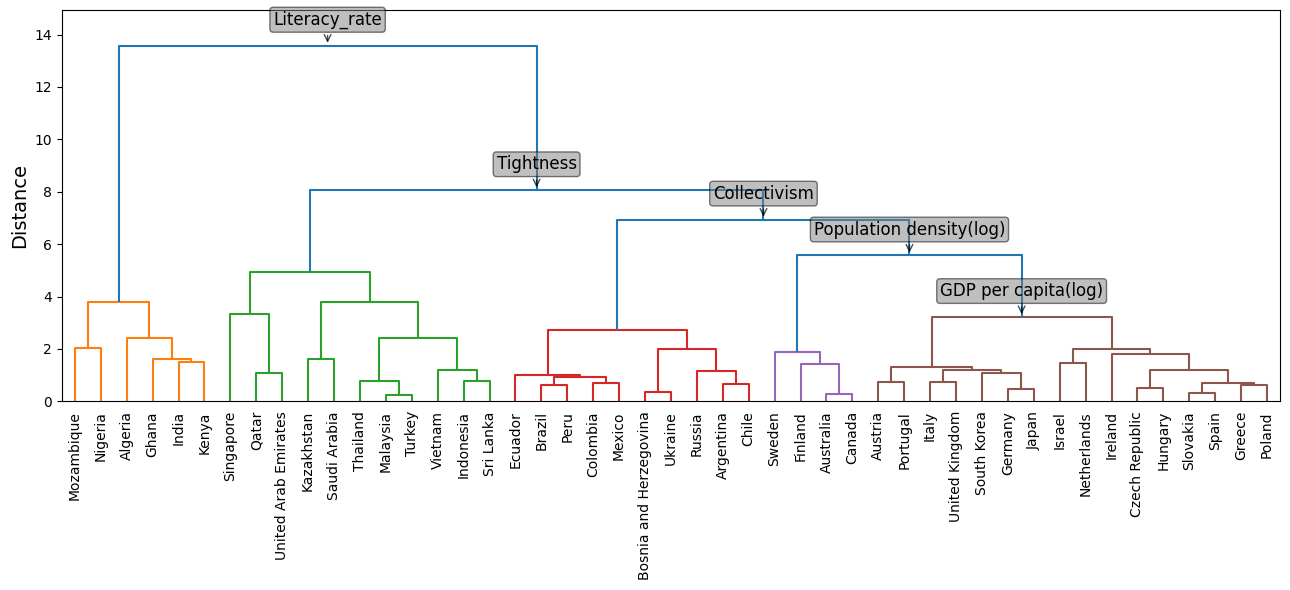

In [41]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# from sklearn.preprocessing import StandardScaler

df1 = df[['Country','Tightness','Collectivism',"GDP per capita(log)","Literacy_rate","Population density(log)"]].dropna()
variables = ['Tightness','Collectivism',"GDP per capita(log)","Literacy_rate","Population density(log)"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df1[variables])

linked = linkage(X_scaled, method='ward')

fig, ax = plt.subplots(figsize=(13, 6))
ddata = dendrogram(
    linked, 
    labels=df1['Country'].values, 
    leaf_rotation=90, 
    leaf_font_size=10, 
    color_threshold=0.4 * max(linked[:, 2]),
    ax=ax
)

# Annotate the main bifurcations with "driver" variables
def get_cluster_indices(n_samples, node):
    """Recursively extract the sample indices from a linkage node."""
    if node < n_samples:
        return [node]
    else:
        left, right = int(linked[node - n_samples, 0]), int(linked[node - n_samples, 1])
        return get_cluster_indices(n_samples, left) + get_cluster_indices(n_samples, right)

n_samples = X_scaled.shape[0]
top_n = 5  # How many top splits to annotate

# Get the top splits by distance (biggest splits)
top_splits = np.argsort(linked[:, 2])[-top_n:]

for split in top_splits:
    left_idx = int(linked[split, 0])
    right_idx = int(linked[split, 1])
    left_inds = get_cluster_indices(n_samples, left_idx)
    right_inds = get_cluster_indices(n_samples, right_idx)
    
    left_mean = X_scaled[left_inds].mean(axis=0)
    right_mean = X_scaled[right_inds].mean(axis=0)
    diff = np.abs(left_mean - right_mean)
    driver_var = variables[np.argmax(diff)]

    # Find coordinates for annotation
    x = 0.5 * (ddata['icoord'][split][1] + ddata['icoord'][split][2])
    y = ddata['dcoord'][split][1]
    ax.annotate(
        driver_var, 
        xy=(x, y), 
        xytext=(x, y+0.8), 
        arrowprops=dict(facecolor='black', arrowstyle='->', lw=1, alpha=0.7),
        ha='center', 
        fontsize=12, 
        bbox=dict(boxstyle='round,pad=0.2', fc='grey', alpha=0.5,ec='black')
    )

ax.set_ylabel('Distance', fontsize=14)
ax.set_ylim(0, max(linked[:, 2]) * 1.1)
plt.tight_layout()
#plt.savefig("Country_HC_SEC_annotated.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()


[1 3 4 5 3 3 4 3 3 5 3 4 5 1 5 5 1 2 5 5 5 5 2 1 2 3 1 5 1 3 5 5 2 3 2 2 5
 5 5 2 4 2 2 3 2 5 2]


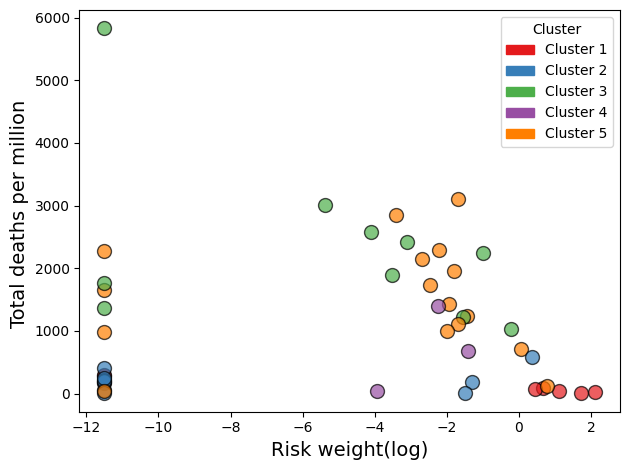

In [43]:
from scipy.cluster.hierarchy import fcluster
colors = [
    "#E41A1C",  # red
    "#377EB8",  # blue
    "#4DAF4A",  # green
    "#984EA3",  # purple
    "#FF7F00",  # orange
    "#A65628",  # brown
    "#F781BF",  # pink
    "#999999",  # grey
    "#66C2A5",  # teal
    "#FFD92F"   # yellow
]
clusters_list = fcluster(linked, t=5, criterion='maxclust')

df['cluster'] = clusters_list
#scaled_df['cluster'] = clusters
#print(df[[ 'cluster']].head())
scaled_df = pd.DataFrame(X_scaled, columns=variables)
scaled_df['Country'] = df1['Country'].values
scaled_df['cluster'] = np.array(clusters_list)
df['total_deaths'] = np.nan

total_deaths_list=[]



fig, ax = plt.subplots()
for country in countries:
    disease_incidence = np.array(new_death_df[new_death_df['country'] == country]['Deaths per mil'])
        
       
    avg_deaths = np.sum(disease_incidence) 
    df.loc[df['Country'] == country, 'total_deaths'] = avg_deaths
    total_deaths_list.append(avg_deaths)
    
    # Use the correct column access for Population_density_log
    pop_density = df[df['Country'] == country]['Population_density'].values[0]
    # Normalize average deaths by population density    
    avg_deaths_norm = avg_deaths / (pop_density)**1
  
    # Get cluster number for the country (subtract 1 for zero-based index)
    cluster_num = int(scaled_df[scaled_df['Country'] == country]['cluster'].values[0]) - 1
    color = colors[cluster_num]
    
    ax.scatter(df[df['Country'] == country]['Risk weight(log)'].values[0], avg_deaths , alpha=0.7, edgecolors='black', c=color, s=100)
#add legend for clusters
handles, labels = ax.get_legend_handles_labels()
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(5)]
handles.extend(patches)
ax.legend(handles=handles, loc='upper right', title='Cluster', fontsize="10", ncol=1, fancybox=True)
ax.set_xlabel('Risk weight(log)', fontsize=14)
ax.set_ylabel('Total deaths per million ', fontsize=14)
#plt.title('Average Deaths vs Risk perception by Country', fontsize=16)
plt.tight_layout()
#plt.savefig("Average_deaths_vs_risk.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [44]:
# Select relevant columns and drop rows with missing values
norm_df = df[['Risk weight', 'Policy weight', 'Norm weight', 'total_deaths']].dropna()

# Standardize the columns (z-score normalization)
for col in ['Risk weight', 'Policy weight', 'Norm weight', 'total_deaths']:
    norm_df[col] = (norm_df[col] - norm_df[col].mean()) / norm_df[col].std()

# Define features and target variable
features = ['Risk weight', 'Policy weight', 'Norm weight']
X = norm_df[features]
X = sm.add_constant(X)  # Add intercept term
y = norm_df['total_deaths']

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_deaths   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.087
Date:                Wed, 17 Sep 2025   Prob (F-statistic):              0.116
Time:                        15:59:33   Log-Likelihood:                -62.991
No. Observations:                  47   AIC:                             134.0
Df Residuals:                      43   BIC:                             141.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           2.81e-16      0.141   1.99e-15

In [45]:
from scipy.stats import ttest_ind

alpha = 0.05

clusters = scaled_df['cluster'].unique()
print(clusters)
variables = ['Tightness','Collectivism',"GDP per capita(log)","Literacy_rate","Population density(log)"]
t_stats_var = pd.DataFrame(index=clusters, columns=variables)
desired_order = [1, 2, 3, 4,5]
t_stats_var = t_stats_var.loc[desired_order]
p_vals_var = pd.DataFrame(index=clusters, columns=variables,dtype=float)
p_vals_var = p_vals_var.loc[desired_order]
for cluster in clusters:
    group = scaled_df[scaled_df['cluster'] == cluster]
    rest = scaled_df[scaled_df['cluster'] != cluster]
    
    for var in variables:
        t_val, p_val = ttest_ind(group[var], rest[var], equal_var=False)
        t_stats_var.loc[cluster, var] = t_val  # Or use p_val if you prefer
        p_vals_var.loc[cluster, var] = p_val
        
t_stats_var = t_stats_var.astype(float)
sig_mask = p_vals_var.astype(float) > alpha


[1 3 4 5 2]


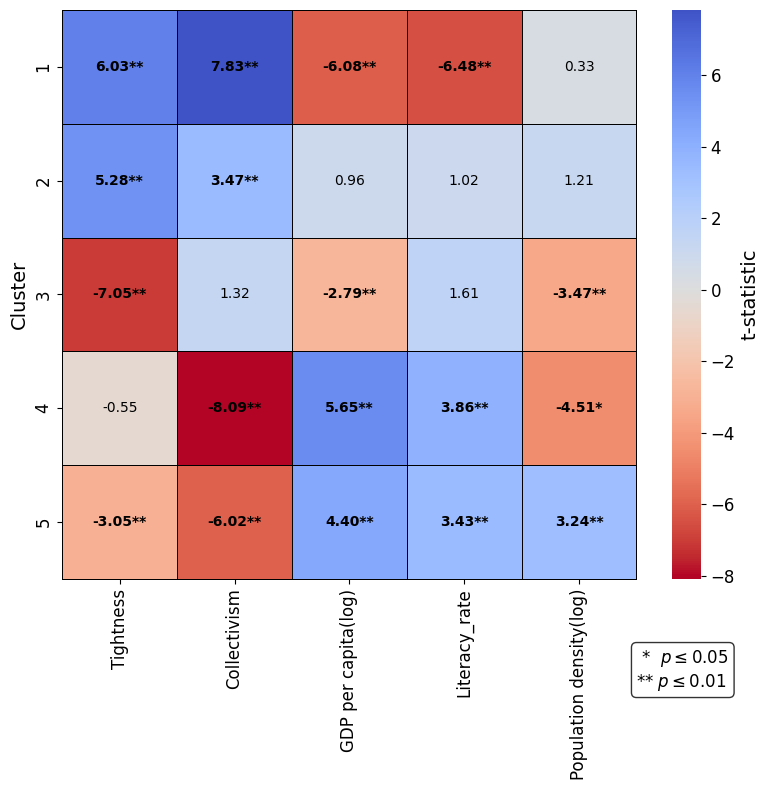

In [46]:
# Create annotation matrix with t-stats and significance stars
annot = t_stats_var.copy().astype(str)

for i in t_stats_var.index:
    for j in t_stats_var.columns:
        t_val = t_stats_var.loc[i, j]
        p_val = p_vals_var.loc[i, j]

        # Decide star level based on p-value
        if p_val <= 0.01:
            stars = '**'
        elif p_val <= 0.05:
            stars = '*'
        #elif p_val <= 0.01:
        #    stars = '*'
        else:
            stars=''

        # Format annotation
        annot.loc[i, j] = f"{t_val:.2f}{stars}"

# Plot heatmap with mask applied
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    t_stats_var, 
    annot=annot,
    #mask=sig_mask,
    fmt="",
    center=0, cmap='coolwarm_r', annot_kws={"color": "black"},
    cbar_kws={'label': 't-statistic'}, linewidths=0.5, linecolor='black', clip_on=False
)

sig_flat = (p_vals_var.values <= 0.05).ravel(order='C')
for txt, sig in zip(ax.texts, sig_flat):
    if sig:
        txt.set_fontweight('bold')

legend_x, legend_y = 1, -0.2  # adjust position relative to plot
legend_text = (
    #r"  *  $p \leq 0.1$" + "\n" +
    r" *  $p \leq 0.05$" + "\n" +
    r"** $p \leq 0.01$"
)
ax.text(
    legend_x, legend_y, legend_text,
    transform=ax.transAxes, fontsize=12,
    verticalalignment='bottom',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)
# Adjust colorbar and labels
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('t-statistic', fontsize=14)
ax.tick_params(labelsize=12)
plt.ylabel('Cluster', fontsize=14)
plt.tight_layout()
#plt.savefig("SEC_T_stat.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)
plt.show()



In [47]:
params_df = df[['Country', 'Norm weight', 'Policy weight', 'Risk weight']].dropna()
parameters = ['Norm weight', 'Policy weight', 'Risk weight']
merged = pd.merge(params_df, df1, on='Country')
merged['cluster'] = np.array(clusters_list)

#print(merged)
param_scaled = scaler.fit_transform(merged[parameters])

param_scaled_df = pd.DataFrame(param_scaled, columns=parameters)
param_scaled_df['cluster'] = merged['cluster'].values


    Norm weight  Policy weight  Risk weight  cluster
0      0.009403      -0.967172     0.870988        1
1      0.619889      -0.574703    -0.374717        3
2      0.171159      -1.064228    -0.391853        4
3     -0.734000       0.068280    -0.309343        5
4      0.182803      -0.820558    -0.401586        3
5      0.700207      -0.860185    -0.393791        3
6      0.746321      -0.733830    -0.244870        4
7      0.795768      -0.173389    -0.404667        3
8      0.557918      -0.924674    -0.157127        3
9      0.448640      -0.770864    -0.382699        5
10     0.812845      -0.636767    -0.404667        3
11     0.566778       0.228123    -0.404667        4
12    -1.956966       2.924148    -0.281814        5
13    -1.965664       0.454209     5.123972        1
14     0.462683      -0.640423    -0.249251        5
15    -0.332260       0.189581    -0.283561        5
16     0.537535      -0.923843    -0.404667        1
17     0.639978      -0.866918    -0.404667   

In [48]:


clusters = param_scaled_df['cluster'].unique()

t_stats = pd.DataFrame(index=clusters, columns=parameters)
desired_order = [1, 2, 3, 4,5]
t_stats = t_stats.loc[desired_order]
p_vals = pd.DataFrame(index=clusters, columns=parameters, dtype=float)
p_vals = p_vals.loc[desired_order]

for cluster in clusters:
    group = param_scaled_df[param_scaled_df['cluster'] == cluster]
    rest = param_scaled_df[param_scaled_df['cluster'] != cluster]
    
    for var in parameters:
        t_val, p_val = ttest_ind(group[var], rest[var], equal_var=False)
        t_stats.loc[cluster, var] = t_val  # Or use p_val if you prefer
        p_vals.loc[cluster, var] = p_val
sig_mask = p_vals.astype(float) > alpha        
t_stats = t_stats.astype(float)
print(p_vals)

   Norm weight  Policy weight  Risk weight
1     0.365255       0.739108     0.049724
2     0.568682       0.494628     0.075827
3     0.507267       0.010471     0.049779
4     0.042302       0.291735     0.027068
5     0.963414       0.144550     0.171225


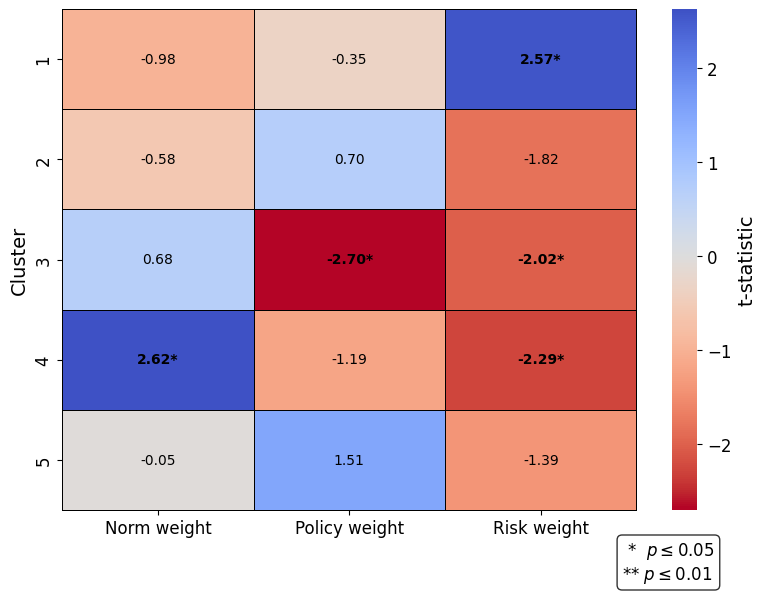

In [49]:
annot = t_stats.copy().astype(str)
for i in t_stats.index:
    for j in t_stats.columns:
        t_val = t_stats.loc[i, j]
        p_val = p_vals.loc[i, j]
        if p_val <= 0.01:
            stars = '**'
        elif p_val <= 0.05:
            stars = '*'
        #elif p_val <= 0.1:
        #   stars = '*'
        else:
            stars = ''
        annot.loc[i, j] = f"{t_val:.2f}{stars}"

# ---- Plot heatmap ----
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    t_stats,  annot=annot, fmt="", 
    center=0, cmap='coolwarm_r', annot_kws={"color": "black"},
    linewidths=0.5, linecolor='black', clip_on=False
)

sig_flat = (p_vals.values <= 0.05).ravel(order='C')
for txt, sig in zip(ax.texts, sig_flat):
    if sig:
        txt.set_fontweight('bold')
        
legend_x, legend_y = 0.975, -0.15  # adjust position relative to plot
legend_text = (
    #r"  *  $p \leq 0.1$" + "\n" +
    r" *  $p \leq 0.05$" + "\n" +
    r"** $p \leq 0.01$"
)
ax.text(
    legend_x, legend_y, legend_text,
    transform=ax.transAxes, fontsize=12,
    verticalalignment='bottom',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('t-statistic', fontsize=14)
ax.tick_params(labelsize=12)
plt.ylabel('Cluster', fontsize=14)
plt.tight_layout()

#plt.savefig("param_T_stat.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)
plt.show()

# Bipartite network using calibrated parameters from all bootstraps

{('Tightness', 'Policy weight'): 79, ('Tightness', 'Risk weight'): 126, ('Collectivism', 'Norm weight'): 86, ('Collectivism', 'Risk weight'): 134, ('GDP per capita(log)', 'Norm weight'): 89, ('GDP per capita(log)', 'Policy weight'): 79, ('GDP per capita(log)', 'Risk weight'): 223, ('Literacy_rate', 'Norm weight'): 86, ('Literacy_rate', 'Risk weight'): 132, ('Population density(log)', 'Norm weight'): 89, ('Population density(log)', 'Policy weight'): 79, ('Population density(log)', 'Risk weight'): 190, ('Tightness', 'Norm weight'): 3}
Edges (Variable -- Parameter) with co-significance counts and product of t-stats:
Tightness -- Policy weight: weight = 79, product = 79.00
Tightness -- Risk weight: weight = 126, product = 91.00
Tightness -- Norm weight: weight = 3, product = -3.00
Collectivism -- Norm weight: weight = 86, product = -86.00
Collectivism -- Risk weight: weight = 134, product = 99.00
GDP per capita(log) -- Norm weight: weight = 89, product = 86.00
GDP per capita(log) -- Policy

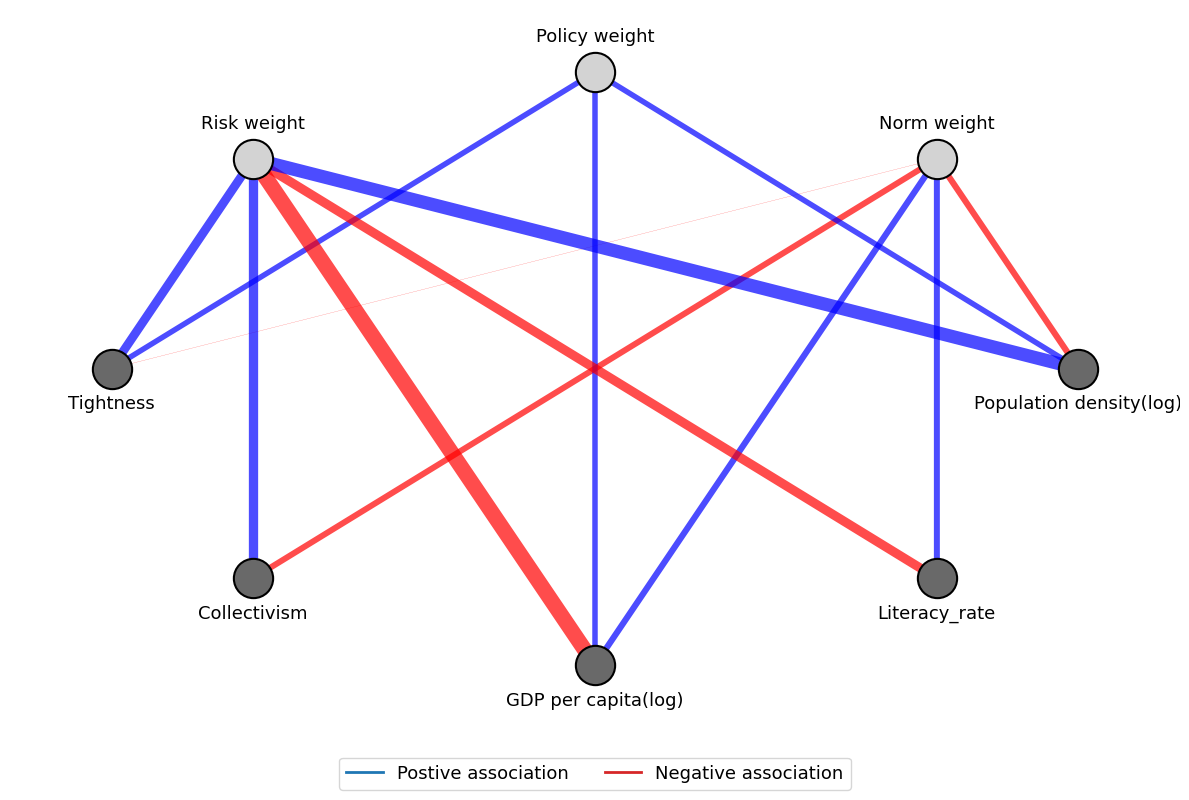

In [52]:
# PREP: lock SCE rows to your countries order exactly
country_order = pd.Index(countries)  # the order that theta_boots uses
sce = df1.set_index('Country')

# clusters_list must be in the SAME order as `countries`
clust = np.asarray(clusters_list)


parameters = ['Norm weight', 'Policy weight', 'Risk weight']
alpha = 0.05
variables = list(variables)  # your SCE variable names

# # accumulators across bootstraps

edge_weights = {}   # number of clusters where both are significant
edge_products = {}  # sum of products of t-stats for those clusters


scaler = StandardScaler()

N = len(country_order)
for b in range(B):
    # params for this bootstrap, already in `countries` order
    
    params_b = theta_boots[:, b, :]  # (N, 3) aligned to countries
    param_df = pd.DataFrame(params_b, columns=['Risk weight','Norm weight', 'Policy weight'])
    param_df['Country'] = [country for country in countries]
    param_df = param_df.sort_values('Country').reset_index(drop=True)
    
    param_df['cluster'] = np.array(clusters_list)
    
    #print(merged)
    param_scaled = scaler.fit_transform(param_df[parameters])
    
    param_scaled_df = pd.DataFrame(param_scaled, columns=parameters)
    param_scaled_df['cluster'] = param_df['cluster'].values

    
    clusters = param_scaled_df['cluster'].unique()

    t_stats = pd.DataFrame(index=clusters, columns=parameters)
    desired_order = [1, 2, 3, 4,5]
    t_stats = t_stats.loc[desired_order]
    p_vals = pd.DataFrame(index=clusters, columns=parameters, dtype=float)
    p_vals = p_vals.loc[desired_order]

    
    for cluster in clusters:
        group = param_scaled_df[param_scaled_df['cluster'] == cluster]
        rest = param_scaled_df[param_scaled_df['cluster'] != cluster]
    
        for par in parameters:
            t_val, p_val = ttest_ind(group[par], rest[par], equal_var=False)
            t_stats.loc[cluster, par] = t_val  # Or use p_val if you prefer
            p_vals.loc[cluster, par] = p_val
    t_stats = t_stats.astype(float)

        
    # co-significance update for this bootstrap
    for var in variables:
        for param in parameters:
            common_sig = 0
            product_sum = 0
            for cluster in p_vals.index:  # Loop through clusters
                # Check significance for the variable (p_vals_var) and parameter (p_vals)
                if (p_vals_var.loc[cluster, var] < alpha) and (p_vals.loc[cluster, param] < alpha):# and t_stats_var.loc[cluster, var] * t_stats.loc[cluster, param]>0:
                    common_sig += 1
                    # Multiply the corresponding t-statistics from each analysis
                    product_sum += t_stats_var.loc[cluster, var] * t_stats.loc[cluster, param]
            if common_sig > 0:
                edge_weights[(var, param)]=edge_weights.get((var,param), 0) + common_sig
                edge_products[(var, param)]= edge_products.get((var,param), 0) + np.sign(product_sum)

print(edge_weights)

G = nx.Graph()

# Add nodes with a bipartite attribute: 0 for variables, 1 for parameters.
G.add_nodes_from(variables, bipartite=0, label='variable')
G.add_nodes_from(parameters, bipartite=1, label='parameter')

# Add edges with both weight and product attributes
for (var, param), weight in edge_weights.items():
    prod = edge_products[(var, param)]
    G.add_edge(var, param, weight=weight, product=prod)

# (Optional) Print the edge list with attributes
print("Edges (Variable -- Parameter) with co-significance counts and product of t-stats:")
for u, v, data in G.edges(data=True):
    print(f"{u} -- {v}: weight = {data['weight']}, product = {data['product']:.2f}")

# Prepare for visualization:
# Create a list of product values from the edge attributes.
edge_product_values = [data['product']/3 for u, v, data in G.edges(data=True)]
edge_widths = [edge_weights[(u, v)]/20 for u, v in G.edges()]
# Set up colormap normalization based on min and max of product values
cmap = plt.cm.coolwarm_r
norm = mpl.colors.Normalize(vmin=min(edge_product_values), vmax=max(edge_product_values))

# Map each edge's product to a color
colors=['blue','red']
edge_colors = [colors[int(val<0)] for val in edge_product_values]

# Get a bipartite layout with variables on one side.

pos = nx.shell_layout(G)

# Create a figure and axis for the graph.
fig, ax = plt.subplots(figsize=(12, 8))

# Draw the graph on the given axis.
nx.draw_networkx_nodes(G, pos, nodelist=variables, node_color='dimgrey', edgecolors='black',
                       linewidths=1.5, node_size=800, label='Variables', ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=parameters, node_color='lightgrey', edgecolors='black',
                       linewidths=1.5, node_size=800, label='Parameters', ax=ax)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, ax=ax,alpha=0.7)

# Shift the label positions upward.
offset = 0.12  # adjust this offset as necessary

label_pos = {node: (x, y + offset if node in parameters else y - offset)
             for node, (x, y) in pos.items()}

nx.draw_networkx_labels(G, label_pos, font_size=13, ax=ax)


# Set up the ScalarMappable and add a colorbar using the axis.
sm1 = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm1.set_array([])

from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0], [0], color='tab:blue', lw=2, label='Postive association'),
    Line2D([0], [0], color='tab:red',  lw=2, label='Negative association')
]
ax.legend(handles=legend_elems, loc='lower center', bbox_to_anchor=(0.5, -0.1),ncol=2, fancybox=True,fontsize=13)

ax.axis('off')
plt.tight_layout()
plt.show()
#fig.savefig("bipartite.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)
#print(pos)

## Temporal validation


In [66]:
start_time = datetime.datetime.now()
# Print the start time
print("Simulation started at:", start_time.strftime("%H:%M"))
st = time.time()

#p = mp.Pool(processes=128)

model='F'

period='cal'

tasks=[]
for i in range(n_countries):
     
    tasks.append((mu, beta, i, period, param_bounds,model))
    

with mp.Pool(processes=144, initializer=_init_worker,
          initargs=(country_data,)) as p:
    chunksize = max(1, len(tasks) // (144 * 8))
    # tasks is a list of tuples matching optimize_one's signature
    results = p.starmap(optimized_grid, tasks, chunksize=chunksize)

country_params_temp, error_list_temp = zip(*results)

country_params_temp=np.array(country_params_temp)

print('Calibration time:', elapsed_time, 'seconds')
country_params_temp.shape=(n_countries,num_of_parameters)





et = time.time()
elapsed_time = et - st


# p.close()
# p.join()


Simulation started at: 16:27
Calibration time: 6.1516029834747314 seconds


In [67]:
cal_error=[]
val_error=[]
for country_id in range(n_countries):
    cd = country_data[country_id]
    di, pm = np.array(cd['disease_incidence']), np.array(cd['policy_mandates'])
    

    idx = cd['idx_cal'] 
    y_obs = cd['mask_obs_cal'] 

    error = country_error(country_params_temp[i], di, pm, idx, y_obs, mu, beta, model)
    cal_error.append(error)

    idx = cd['idx_val'] 
    y_obs = cd['mask_obs_val']
    error = country_error(country_params_temp[i], di, pm, idx, y_obs, mu, beta, model)
    val_error.append(error)


file_name = f'cal_val_error_{model}.pickle'
# with open(file_name, 'wb') as f:
#     pickle.dump((cal_error, val_error), f)


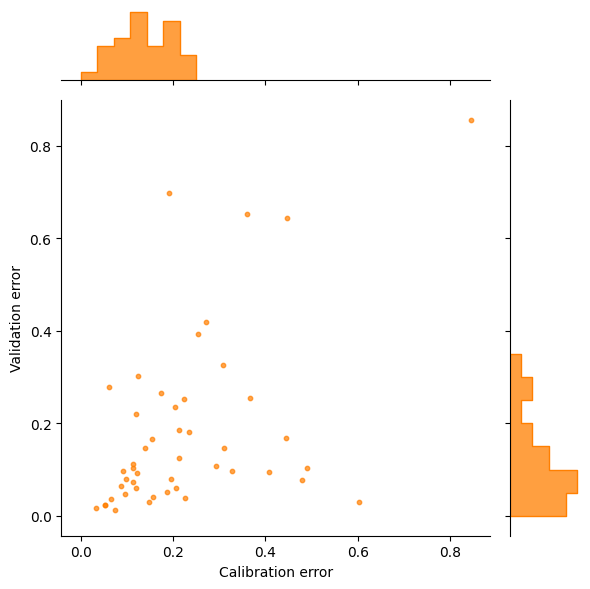

In [68]:
#model_list = ['A', 'C', 'E','G']

model_names=['Policy + Risk + Norm']
model_name='Policy + Risk + Norm'
g = sns.JointGrid()

g.ax_joint.scatter(cal_error, val_error, label=model_name, color=color, alpha=0.7, s=10)

# Add the marginal distributions

sns.histplot(x=cal_error, ax=g.ax_marg_x,stat='density', element='step', common_norm=False, bins=np.linspace(0,0.25,8),color=color)

sns.histplot( y=val_error, ax=g.ax_marg_y,stat='density', element='step', common_norm=False, bins=np.linspace(0,0.35,8),color=color)


#df['model_name']=['Policy','Policy + Risk perception','Policy + Conformity','Policy + Risk perception + Conformity']

# # Plot jointplot with contour (KDE)
# g = sns.jointplot(
#     data=df,
#     x='cal_error', y='val_error'
#     #hue='model',
#     #palette=colors
   
# )

#g.ax_joint.set_xlim(0, df['cal_error'].max() + 0.05)
#g.ax_joint.set_ylim(0, df['val_error'].max() + 0.05)
# g.ax_joint.axhline(y=0.05, c='k', linestyle='--', linewidth=0.5)
# g.ax_joint.axhline(y=0.1, c='k', linestyle='--', linewidth=0.5)
# g.ax_joint.axvline(x=0.05, c='k', linestyle='--', linewidth=0.5)
# g.ax_joint.axvline(x=0.1, c='k', linestyle='--', linewidth=0.5)

g.ax_joint.set_xlabel('Calibration error')
g.ax_joint.set_ylabel('Validation error')
g.fig.tight_layout()
plt.show()
#g.fig.savefig("Cal_val_1.jpeg",dpi=400,bbox_inches='tight', pad_inches=0.1)

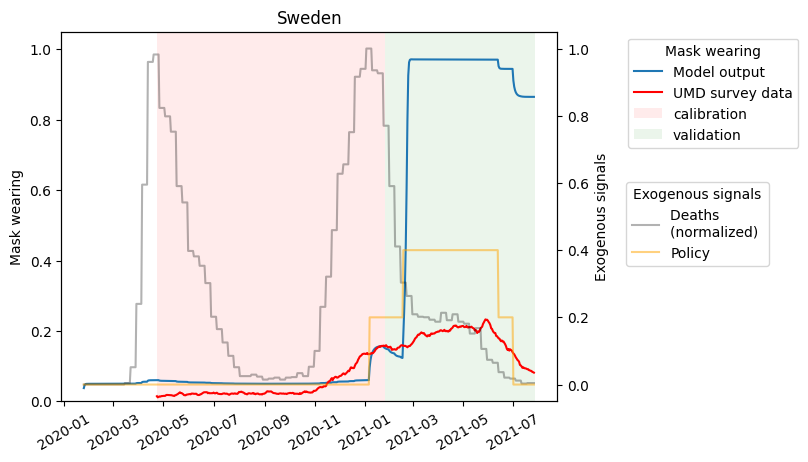

In [73]:
country='Sweden'



country_id=countries.index(country)

disease_incidence = np.array(new_death_df[new_death_df['country'] == country]['Deaths per mil'])

policy_mandates = np.array(policy_df[policy_df['Country'] == country]['H6M_Facial Coverings'])


mask_predicted=country_predicted(disease_incidence, policy_mandates, country_params_temp[country_id], mu, beta, model)

disease_incidence=(disease_incidence-min(disease_incidence))/(max(disease_incidence)-min(disease_incidence))
policy_mandates=(policy_mandates-min(policy_mandates))/5

mask_umd_val = mask_df_val[mask_df_val['country'] == country]['pct']
mask_umd_cal = mask_df_cal[mask_df_cal['country'] == country]['pct']

cal_date_umd=mask_df_cal[mask_df_cal['country'] == country]['days_from_reference']
val_date_umd=mask_df_val[mask_df_val['country'] == country]['days_from_reference']


fig,ax= plt.subplots()
ax.set_ylim(0,1.05)
ax.plot(date_range,mask_predicted,label='Model output')
plt.xticks(rotation=30)
ax2=ax.twinx()

ax2.plot(date_range,disease_incidence,label='Deaths \n(normalized) ',c='k',alpha=0.3)
ax2.plot(date_range,policy_mandates,label='Policy',c='orange',alpha=0.5)
ax.plot(date_range[val_date_umd],mask_umd_val,label='UMD survey data',c='r')
ax.plot(date_range[cal_date_umd],mask_umd_cal,c='r')
ax.bar(date_range[cal_date_umd][0],bottom=0.0, width=len(cal_date_umd), color='r', edgecolor=None, align='edge',height=1.05,alpha=0.08,label='calibration')
ax.bar(date_range[val_date_umd][0],bottom=0.0, width=len(val_date_umd), color='g', edgecolor=None, align='edge',height=1.05,alpha=0.08,label='validation')



ax.set_ylabel('Mask wearing')
ax2.set_ylabel('Exogenous signals')
ax.set_title(country)


ax.legend(loc='upper right',fontsize="10", bbox_to_anchor=(1.5, 1),title='Mask wearing')
ax2.legend(loc='center right',fontsize="10", bbox_to_anchor=(1.44, 0.48),title='Exogenous signals')
plt.show()